In [2]:
import sys

assert sys.version_info >= (3,7)

In [3]:
from packaging import version 
import sklearn 

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Font-sizes to make the figures preetier

In [4]:
import matplotlib.pyplot as plt 

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [5]:
from pathlib import Path 

IMAGES_PATH = Path() / "images" / "classification" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True) 

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path  = IMAGES_PATH / f"{fig_id}.{fig_extension}" 
    if tight_layout:
        plt.tight_layout() 
    plt.save(path, format=fig_extension, dpi=resolution)

### MNIST

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

c:\Users\heito\OneDrive\Área de Trabalho\projects\homl3\.venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X,y = mnist.data, mnist.target 
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
print(X.shape)

(70000, 784)


70k images with 784 features each. 

There are 784 features because each image is made up of 28x28 pixels. 

So each feature is actually a pixel intensity from 0 to 255 (black)

In [10]:
def plot_digit(image_data):
    image = image_data.reshape(28,28) 
    plt.imshow(image, cmap="binary") 
    plt.axis("off")

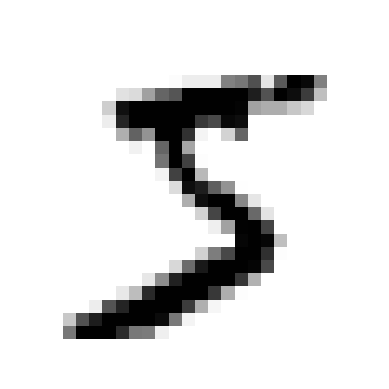

In [12]:
some_digit = X[0] 
plot_digit(some_digit) 
plt.show()

In [13]:
y[0]

'5'

### Splitting the data

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

This data is already shuffled. So that ensures that each fold has the same proportion between classes

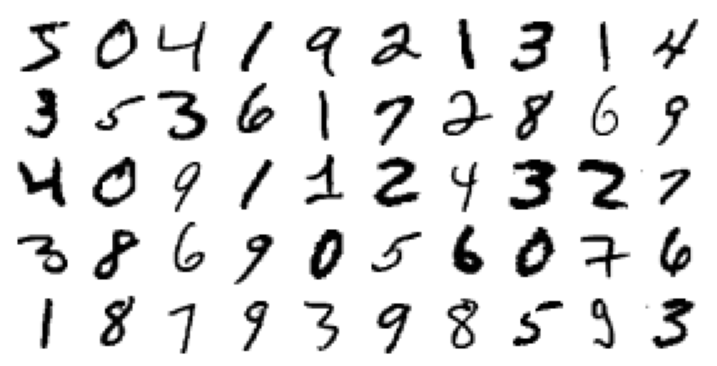

In [19]:
plt.figure(figsize=(9,9)) 

for idx, image_data in enumerate(X[:50]):
    plt.subplot(10,10,idx+1) 
    plot_digit(image_data) 
plt.subplots_adjust(wspace=0, hspace=0) 
plt.show()

### Training a Binary Classifier

Binary classifier to only identify the number 5

In [21]:
y_train_5 = (y_train == '5') 
y_test_5 = (y_test == '5')

In [22]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

In [24]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [25]:
from sklearn.dummy import DummyClassifier 

dummy_clf = DummyClassifier() 
dummy_clf.fit(X_train, y_train_5) 
print(any(dummy_clf.predict(X_train)))

False


In [26]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

### Implementing Cross-Validation

In [27]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3) 

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #does a deep copy of the sgd_clf without copying the data into it 
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index] 

    clone_clf.fit(X_train_fold, y_train_fold) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


## Confusion Matrix

In [28]:
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [32]:
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_train_5, y_train_pred) 
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Precision and Recall

#### Precision

In [33]:
from sklearn.metrics import precision_score, recall_score 

precision_score(y_train_5, y_train_pred)

0.8370879772350012

Out of all predictions made, the model was right 83% of the time

#### Recall

In [34]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

The model got right 65% of all 5 digits

### F1 Score

In [35]:
from sklearn.metrics import f1_score 

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

In [36]:
y_scores = sgd_clf.decision_function([some_digit]) 
y_scores

array([2164.22030239])

### How to define the threshold for classification?

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [39]:
from sklearn.metrics import precision_recall_curve 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 

In [40]:
threshold = 3000

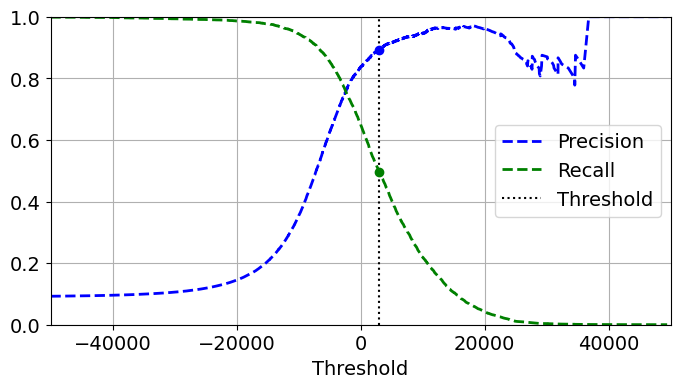

In [42]:
plt.figure(figsize=(8,4)) 
plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g--', label="Recall", linewidth=2) 
plt.vlines(threshold, 0,1., 'k', "dotted", label="Threshold") 
# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

### Precision X Recall

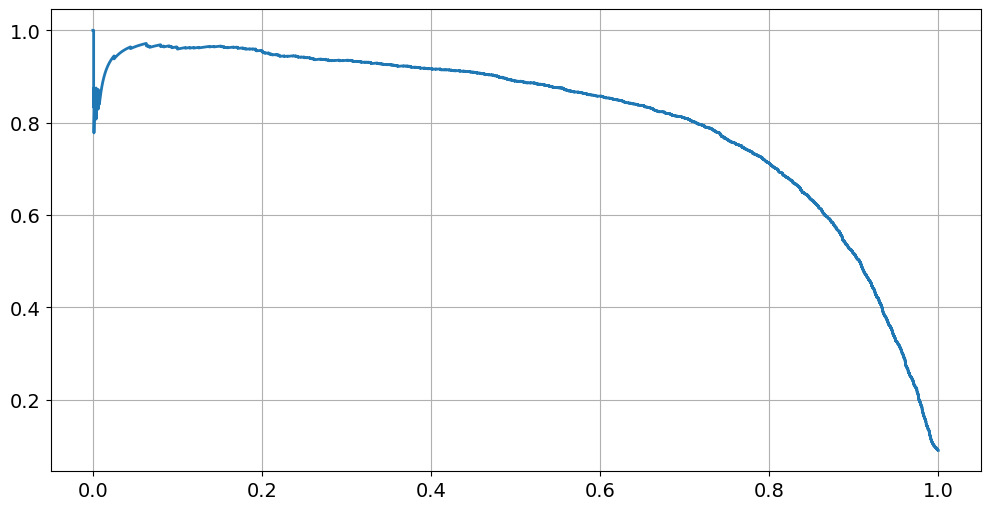

In [44]:
plt.figure(figsize=(12,6)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall Curve") 
plt.grid()
plt.show()

In [47]:
import pandas as pd 

precision_recall_df = pd.DataFrame({"precision":precisions, "recall":recalls})

In [49]:
precision_recall_df.sort_values(by="precision", ascending=False)

,precision,recall
60000,1.000000,0.000000
59995,1.000000,0.000922
59999,1.000000,0.000184
59998,1.000000,0.000369
59997,1.000000,0.000553
...,...,...
4,0.090356,1.000000
3,0.090355,1.000000
2,0.090353,1.000000
1,0.090352,1.000000


Suppose we want 90% precision.

we can look for the lowest threshold that gives me at least 90%

In [51]:
idx_for_90_precision = (precisions >=.9).argmax() 

print(idx_for_90_precision) 

threshold_for_90_precision = thresholds[idx_for_90_precision] 

print("Threshold for 90% Precision", threshold_for_90_precision)

57109
Threshold for 90% Precision 3370.0194991439557


### ROC Curve

In [52]:
from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

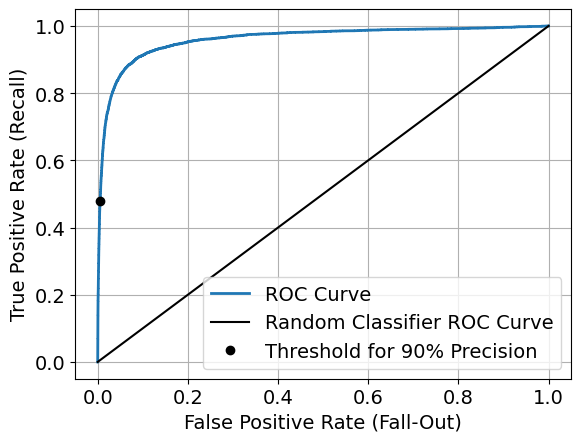

In [56]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax() 
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90] 

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve") 
plt.plot([0,1], [0,1], 'k', label='Random Classifier ROC Curve') 
plt.plot([fpr_90], [tpr_90], 'ko', label="Threshold for 90% Precision") 

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## MultiClass Classification

In [58]:
from sklearn.svm import SVC 

svm_clf = SVC(random_state=42) 
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [59]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

SVM Classifier uses the One versus One Method for classification, since it's a binary classifier. 

So, actually it made 45 predictions, one per pair of classes.

In [60]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [63]:
some_digits_scores = svm_clf.decision_function([some_digit]) 
some_digits_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [64]:
class_id = some_digits_scores.argmax() 
class_id

5

In [65]:
svm_clf.classes_[class_id]

'5'

Let's get all 45 OvO Scores for each training instance 

In [66]:
svm_clf.decision_function_shape = "ovo" #that's an hyperparameter - an instance variable of the object
some_digit_scores_ovo = svm_clf.decision_function([some_digit]) 

some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

## Selecting OvO or OvR

In [67]:
from sklearn.multiclass import OneVsRestClassifier 

ovr_clf = OneVsRestClassifier(SVC(random_state=42)) 
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [68]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [69]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

As we can see it creates 10 SVC. One for each class

## SGD Classifier Multiclass

In [71]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [72]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

## Error Analysis

In [74]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.astype("float64")) 
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

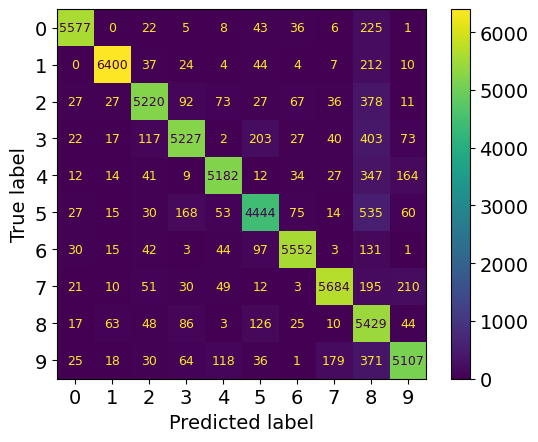

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay 

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 
plt.rc('font', size=9) 
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred) 
plt.show()

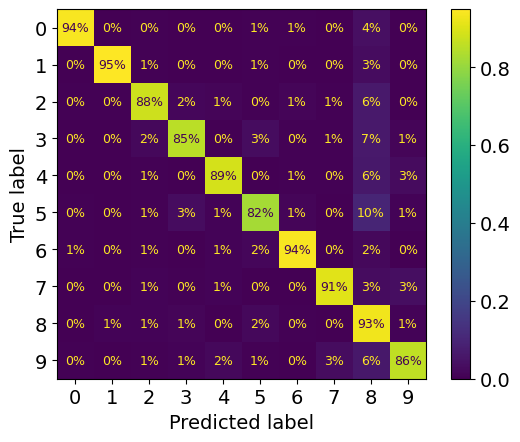

In [76]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

Putting weights on the errors only

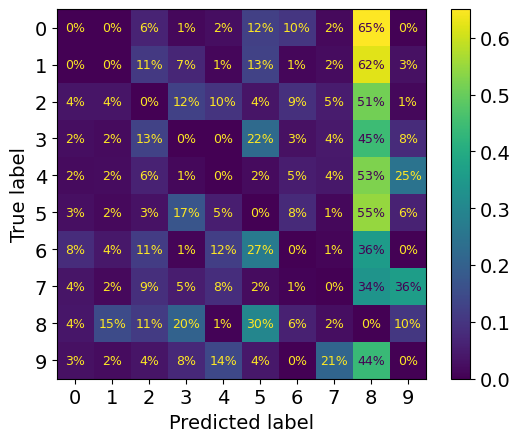

In [77]:
sample_weight = (y_train_pred != y_train) 
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight, normalize="true", values_format=".0%")

**Interpretation**

For the confusion matrix above, we've put the weights only on the errors. So it's a confusion matrix of the normalized errors. 

It means that, for example, for the class 0, 65% of the errors were of missclassification as 8. 

It does not mean that 65% of all 0's were missclassified as 8

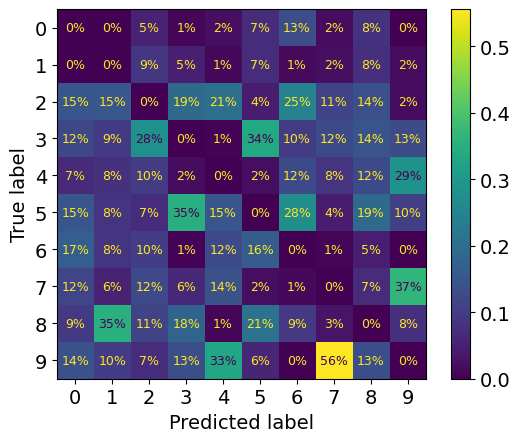

In [79]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")

#### Analyzing Individual Errors

In [85]:
cl_a, cl_b = '3', '5' 
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

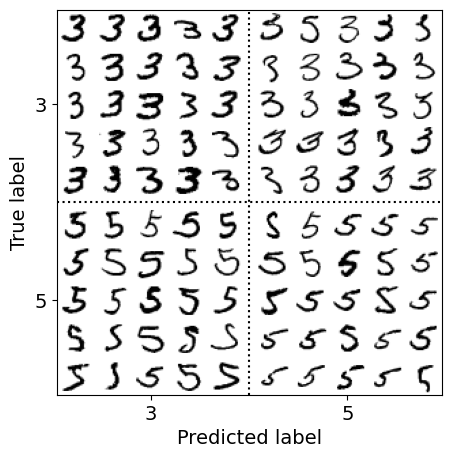

In [87]:
size = 5 
pad = 0.2 
plt.figure(figsize=(size,size)) 
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad) 
        plt.imshow(image_data.reshape(28,28), cmap="binary", extent=(x, x+1, y, y+1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Multilabel Classification

In [90]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier 

y_train_large = (y_train >= '7') 
y_train_odd = (y_train.astype('int8') % 2 == 1) 
y_multilabel = np.c_[y_train_large, y_train_odd] 

knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [91]:
knn_clf.predict([some_digit])

array([[False,  True]])

Computing the F1Score for each label and taking the average

In [92]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) 
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### Chain Classifier

In [93]:
from sklearn.multioutput import ClassifierChain 

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42) 
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [94]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## MultiOutput Classification

In [95]:
np.random.seed(42) 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

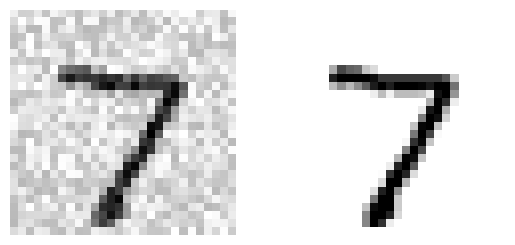

In [96]:

# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0]) 
plt.show()

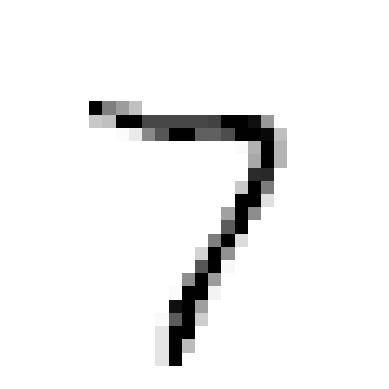

In [97]:
knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train_mod, y_train_mod) 
clean_digit = knn_clf.predict([X_test_mod[0]]) 
plot_digit(clean_digit) 
plt.show()